In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/MyDrive/police_records_project'
os.chdir(project_path)
print(f"Working directory: {os.getcwd()}")

Working directory: /content/drive/MyDrive/police_records_project


In [3]:
!pip install -q sentence-transformers scikit-learn umap-learn plotly

In [4]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [6]:
input_file = "data/processed/extracted_texts.json"

with open(input_file, 'r', encoding='utf-8') as f:
    texts_data = json.load(f)

print(f"Loaded {len(texts_data)} documents")

texts = [doc['text'] for doc in texts_data]
filenames = [doc['filename'] for doc in texts_data]

Loaded 113 documents


In [43]:
# model_name = 'all-MiniLM-L6-v2' # small
# model_name = 'all-mpnet-base-v2' # medium
model_name = 'intfloat/e5-large-v2' # large

model = SentenceTransformer(model_name, device=device)

print(f" Embedding dimension: {model.get_sentence_embedding_dimension()}")

 Embedding dimension: 1024


In [44]:
if 'e5' in model_name:
    texts_to_encode = [f"passage: {text}" for text in texts]
else:
    texts_to_encode = texts


embeddings = model.encode(
    texts_to_encode,
    show_progress_bar=True,
    batch_size=16,
    device=device
)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [45]:
output_path = Path("data/processed")

np.save(output_path / "embeddings.npy", embeddings)

with open(output_path / "filenames.json", 'w') as f:
    json.dump(filenames, f, indent=4)

In [46]:
k_range = range(2, 25)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings, labels))
    print(f"k={k} -> silhouette={silhouette_scores[-1]:.3f}")

k=2 -> silhouette=0.074
k=3 -> silhouette=0.040
k=4 -> silhouette=0.040
k=5 -> silhouette=0.053
k=6 -> silhouette=0.054
k=7 -> silhouette=0.059
k=8 -> silhouette=0.077
k=9 -> silhouette=0.071
k=10 -> silhouette=0.082
k=11 -> silhouette=0.096
k=12 -> silhouette=0.087
k=13 -> silhouette=0.104
k=14 -> silhouette=0.114
k=15 -> silhouette=0.101
k=16 -> silhouette=0.104
k=17 -> silhouette=0.136
k=18 -> silhouette=0.136
k=19 -> silhouette=0.143
k=20 -> silhouette=0.139
k=21 -> silhouette=0.148
k=22 -> silhouette=0.146
k=23 -> silhouette=0.162
k=24 -> silhouette=0.159


Text(0.5, 1.0, 'Silhouette Score')

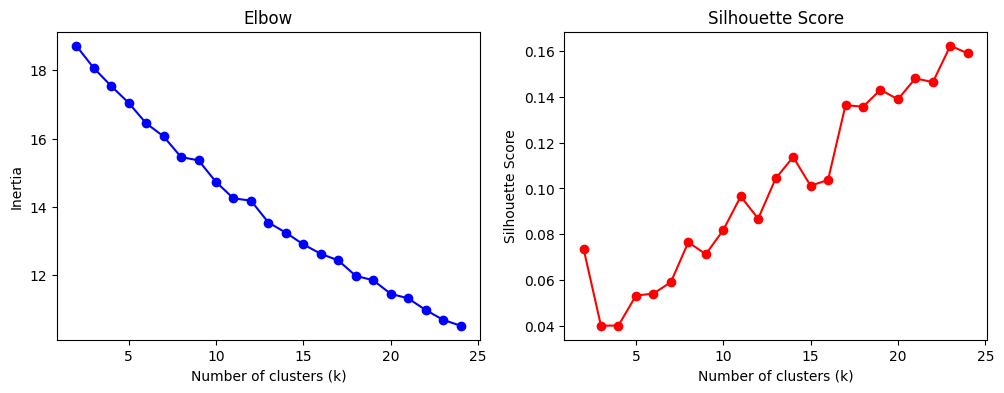

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')

In [48]:
n_clusters = 12

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

In [49]:
clusters = {}
for filename, label in zip(filenames, labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(filename)

print("\nCluster sizes:")
for label in sorted(clusters.keys()):
    print(f"Cluster {label}: {len(clusters[label])} documents")


Cluster sizes:
Cluster 0: 7 documents
Cluster 1: 7 documents
Cluster 2: 5 documents
Cluster 3: 21 documents
Cluster 4: 6 documents
Cluster 5: 6 documents
Cluster 6: 1 documents
Cluster 7: 27 documents
Cluster 8: 11 documents
Cluster 9: 11 documents
Cluster 10: 8 documents
Cluster 11: 3 documents


In [50]:
result_path = Path("results")

results = [
    {'filename': fname, 'cluster': int(label)}
    for fname, label in zip(filenames, labels)
]

with open(result_path / "cluster_assignments.json", 'w') as f:
    json.dump(results, f, indent=4)

clusters_grouped = {int(k): v for k, v in clusters.items()}
with open(result_path / "clusters_grouped.json", 'w') as f:
    json.dump(clusters_grouped, f, indent=4)

print(f"Saved results to {result_path}")

Saved results to results


In [51]:
reducer = umap.UMAP(
    n_neighbors=len(embeddings)-1,
    min_dist=0.1,
    n_components=2,
    random_state=42,
    metric='cosine'
)

embedding_2d = reducer.fit_transform(embeddings)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [58]:
plot_data = pd.DataFrame({
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'cluster': labels.astype(str),
    'filename': filenames,
    'cluster_size': [sum(labels == label) for label in labels]
})

fig = px.scatter(
    plot_data,
    x='x',
    y='y',
    color='cluster',
    hover_data=['filename', 'cluster_size'],
    labels={'x': 'UMAP Dimension 1', 'y': 'UMAP Dimension 2', 'cluster': 'Cluster'},
    title='Document Clusters',
    width=1200,
    height=700,
)

fig.show()